In [1]:
import torch
import torchvision
import numpy as np

from torch import nn 
from torch import optim
from torch.utils import data

# реализация критерия ранней остановки
from tools.pytorchtools import EarlyStopping

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Задание 1

Добиться вразумительного результата от модели, собранной на занятии (7 угаданныx картинок из 10 предложенных на семинаре).

Реализованные идеи (проверял поэтапно, постепенно улучшая скор):
* Добавил валидационный набор данных, чтобы отслеживать лосс не только на тренировочных данных
* Добавил раннюю остановку и обучал до тех пор пока качество на валидации не начнет падать
* За базовую модель взял модель, состоящую из 3 VGG блоков с 32, 64 и 128 наборами параметров соответственно
* Добавил предобработку:
    - нормализовал значения в тензоре при помощи среднего и стандартного отклонения по всей выборке
    - добавил несложную аугментацию: 30 процентов вероятность отразить картинку по вертикали и горизонтали
* Заменил оптимизатор на Adam. Он адаптивный, быстрее сходится и в нем не так сильна зависимость размера батча и скорости обучения
* Добавил в модель dropout слои. Пробовал различные конфигурации с константным и постепенно возрастающим шансом отбросить нейрон. Лучше сработало в варианте с постепенным возрастанием
* Добавил нормализацию батча после каждого слоя. Пробовал в двух вариантах: до и после ReLu, так как однозначного ответа, как лучше это делать не нашел. Лучше сработало при добавлении после функции активации
* Пробовал заменить пулинговые слои на свертку со страйдом. Идея была получить еще один обучаемый слой, который по размерностям работал бы аналогично пулингу, но эффекта это не дало

Финальный скор модели на тестовой выборке: 84.29%

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# основные параметры
batch_size = 2048
n_epochs = 400
num_classes = 10
patience = 10

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, 
                         rgb_std),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, 
                         rgb_std),
])

In [7]:
# скачиваем датасеты
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,  
                                             transform=train_transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Устнанавливаем размер тренировочной и валидационной выборок
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size

In [9]:
# Разделение на train-validation
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [10]:
# Откуда взялись значения для нормализации
mean_train = torch.mean(torch.Tensor.float(torch.from_numpy(train_set.dataset.data) / 255), dim=(0, 1, 2))
std_train = torch.std(torch.Tensor.float(torch.from_numpy(train_set.dataset.data) / 255), dim=(0, 1, 2))

print(mean_train)
print(std_train)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [11]:
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [12]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv21 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv31 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.bnorm1 = nn.BatchNorm2d(32)
        self.bnorm11 = nn.BatchNorm2d(32)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.bnorm21 = nn.BatchNorm2d(64)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.bnorm31 = nn.BatchNorm2d(128)
        self.bnorm4 = nn.BatchNorm1d(128)

        
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.4)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bnorm1(x)
        x = F.relu(self.conv11(x))
        x = self.bnorm11(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bnorm2(x)
        x = F.relu(self.conv21(x))
        x = self.bnorm21(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv3(x))
        x = self.bnorm3(x)
        x = F.relu(self.conv31(x))
        x = self.bnorm31(x)
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.bnorm4(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


net = Net().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [14]:
def train_model(model, patience, n_epochs, device): 
    """Function trains given model during n_epochs with early stopping
    criteria: train stops if validation loss does not decrease 
    during {patience} epochs.
    For correct work 'train_loader' and 'val_loader' must be defined
    
    Input
    -----
    model: neural network for training
    patience: int, number of epochs for early stopping
    n_epochs: int, number of epochs for training
    device: torch.device
    
    Output
    ------
    model: neural network loaded from checkpoint.pt.
           Last step of model when validation loss decreased
    avg_train_losses: list with average values of loss function 
                      during training through epochs
    avg_valid_losses: list with average values of loss function 
                      during validating through epochs
    """
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for batch, data in enumerate(train_loader, 1):
            data, target = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data in val_loader:
            data, target = data[0].to(device), data[1].to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [15]:
model, train_loss, valid_loss = train_model(net, patience, n_epochs, device)

[  1/400] train_loss: 2.00869 valid_loss: 2.51237
Validation loss decreased (inf --> 2.512373).  Saving model ...
[  2/400] train_loss: 1.69349 valid_loss: 1.58187
Validation loss decreased (2.512373 --> 1.581870).  Saving model ...
[  3/400] train_loss: 1.55968 valid_loss: 1.39346
Validation loss decreased (1.581870 --> 1.393457).  Saving model ...
[  4/400] train_loss: 1.46901 valid_loss: 1.28735
Validation loss decreased (1.393457 --> 1.287346).  Saving model ...
[  5/400] train_loss: 1.39570 valid_loss: 1.24249
Validation loss decreased (1.287346 --> 1.242485).  Saving model ...
[  6/400] train_loss: 1.34102 valid_loss: 1.18709
Validation loss decreased (1.242485 --> 1.187086).  Saving model ...
[  7/400] train_loss: 1.27046 valid_loss: 1.13669
Validation loss decreased (1.187086 --> 1.136685).  Saving model ...
[  8/400] train_loss: 1.22375 valid_loss: 1.08338
Validation loss decreased (1.136685 --> 1.083378).  Saving model ...
[  9/400] train_loss: 1.18799 valid_loss: 1.02939
Val

[ 79/400] train_loss: 0.54790 valid_loss: 0.55223
EarlyStopping counter: 1 out of 10
[ 80/400] train_loss: 0.55313 valid_loss: 0.54591
EarlyStopping counter: 2 out of 10
[ 81/400] train_loss: 0.55625 valid_loss: 0.54879
EarlyStopping counter: 3 out of 10
[ 82/400] train_loss: 0.54993 valid_loss: 0.54389
EarlyStopping counter: 4 out of 10
[ 83/400] train_loss: 0.55356 valid_loss: 0.54994
EarlyStopping counter: 5 out of 10
[ 84/400] train_loss: 0.56670 valid_loss: 0.54963
EarlyStopping counter: 6 out of 10
[ 85/400] train_loss: 0.54919 valid_loss: 0.54193
EarlyStopping counter: 7 out of 10
[ 86/400] train_loss: 0.53799 valid_loss: 0.54158
Validation loss decreased (0.541600 --> 0.541583).  Saving model ...
[ 87/400] train_loss: 0.54042 valid_loss: 0.53719
Validation loss decreased (0.541583 --> 0.537194).  Saving model ...
[ 88/400] train_loss: 0.54730 valid_loss: 0.54277
EarlyStopping counter: 1 out of 10
[ 89/400] train_loss: 0.53977 valid_loss: 0.53526
Validation loss decreased (0.537

### График функции потерь

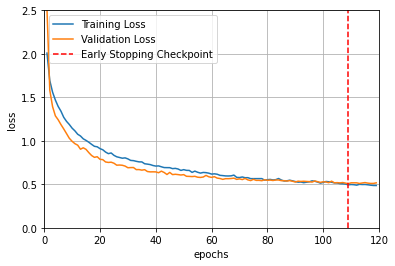

In [16]:
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.show()

### Проверка на отложенном даатсете

In [25]:
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

model.eval()

for batch, data in enumerate(test_loader, 1):
    data, target = data[0].to(device), data[1].to(device)
    if len(target.data) != batch_size:
        break
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    
    # for multiclass: _, pred = torch.max(output, 1)
    _, pred = torch.max(output, 1)
    
    correct = np.squeeze(pred.eq(target.data))

    for i in range(batch_size):
        label = target.data[i]
        label = label.int()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]}: {class_accuracy:.2f}% '\
              f'({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
              
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print(f'\nTest Accuracy (Overall): {overall_accuracy:.2f}% '\
      f'({np.sum(class_correct)}/{np.sum(class_total)})')

Test Loss: 0.389090

Test Accuracy of plane: 84.41% (682/808)
Test Accuracy of car: 93.88% (783/834)
Test Accuracy of bird: 76.63% (636/830)
Test Accuracy of cat: 66.91% (546/816)
Test Accuracy of deer: 84.27% (691/820)
Test Accuracy of dog: 80.63% (670/831)
Test Accuracy of frog: 88.82% (723/814)
Test Accuracy of horse: 85.36% (694/813)
Test Accuracy of ship: 89.47% (731/817)
Test Accuracy of truck: 92.58% (749/809)

Test Accuracy (Overall): 84.29% (6905/8192)


In [26]:
del train_loader
del test_loader
del val_loader
del net
del data
del target
torch.cuda.empty_cache()

## Задание 2

Переписать данный туториал на pytorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [27]:
n_epochs = 5
batch_size = 64

In [28]:
train_dataset = torchvision.datasets.MNIST(root='./data_mnist',
                                           train=True,  
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data_mnist', 
                                          train=False,
                                          download=True, 
                                          transform=transforms.ToTensor())

In [29]:
from torch.utils import data

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
    
model = Net().to(device)

In [31]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [32]:
train_losses = []
avg_train_losses = [] 

for epoch in range(1, n_epochs + 1):
    model.train()
    for batch, data in enumerate(train_loader, 1):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.average(train_losses)
    avg_train_losses.append(train_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ')

    print(print_msg)

    train_losses = []

[1/5] train_loss: 0.38672 
[2/5] train_loss: 0.18552 
[3/5] train_loss: 0.13761 
[4/5] train_loss: 0.11200 
[5/5] train_loss: 0.09418 


In [33]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0914, Accuracy: 9724/10000 (97%)

